In [3]:
#Import all libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

import string
import seaborn as sns
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
import gensim as gsm



In [4]:
#!/usr/bin/env python
"""Wrapper for word2vec and emoji2vec models, so that we can query by entire phrase, rather than by
individual words.
"""

# External dependencies
import os.path
import gensim.models as gs
import numpy as np
from underthesea import word_tokenize
import string

class Word2VecCustom:
    def __init__(self, dim, w2v, e2v=None):
        self.wordVecModel = w2v
        self.emojiVecModel = e2v if e2v is not None else dict()
        self.dimension = dim

    @classmethod
    def from_word2vec_paths(cls, dim, w2v_path):
        w2v = gs.Word2Vec.load(w2v_path)
        return cls(dim, w2v)

    def __getitem__(self, item):
        bang_xoa = str.maketrans('', '', string.punctuation)
        item = item.translate(bang_xoa)
        # tokens = item.split(' ')
        tokens = word_tokenize(item)
        phr_sum = np.zeros(self.dimension, np.float32)

        for token in tokens:
            print(token)
            if token in self.wordVecModel.wv:  # SỬA Ở ĐÂY
                phr_sum += self.wordVecModel.wv[token]  # SỬA Ở ĐÂY
        return phr_sum
    
    def __setitem__(self, key, value):
        self.wordVecModel.wv[key] = value  # SỬA Ở ĐÂY

In [5]:
# Định nghĩa kích thước vector (thường là 300 cho Word2Vec)
vector_dim = 300

# Đường dẫn đến các mô hình
# word2vec_path = 'word2vec_dth_format.model'
word2vec_path = 'model_sg.word2vec'
emoji2vec_path = 'emoji2vec.bin'  # Nếu bạn có mô hình Emoji2Vec

phrase_vec = Word2VecCustom.from_word2vec_paths(dim=vector_dim, w2v_path=word2vec_path)


In [6]:
phrase = "sad"
vector = phrase_vec[phrase]
print(vector)

sad
[-1.90836981e-01  6.95604905e-02  6.29754066e-02  3.97940502e-02
 -1.12669654e-01 -7.17872530e-02  6.33020028e-02  3.09999913e-01
  7.37926513e-02 -1.19475350e-01 -9.24578756e-02 -2.31047004e-01
  1.50352661e-02 -1.11309569e-02 -6.61682859e-02 -5.36073931e-02
  1.10912599e-01 -7.50479195e-03 -1.22542540e-02 -1.22553363e-01
  2.76523586e-02 -1.29931539e-01  1.30544543e-01  5.85087053e-02
  9.09554884e-02 -4.07748111e-02 -2.49571443e-01  7.27907792e-02
 -2.29663514e-02 -3.02549154e-01  4.99971956e-02  5.33083566e-02
  7.40927272e-03  1.61673442e-01 -2.20670715e-01 -1.90379494e-03
  5.15685305e-02 -1.24033444e-01 -7.96941444e-02  8.07926282e-02
 -6.24323934e-02 -4.10695001e-03  4.46534082e-02 -7.12468624e-02
 -1.78301949e-02  1.10171400e-01 -1.06818095e-01  1.01900153e-01
  3.52532566e-02  6.73614442e-02 -2.20539756e-02  1.42763937e-02
  1.22220181e-01 -1.77147333e-02  7.82691166e-02  1.93419755e-01
  1.94165856e-01  5.46654798e-02  7.14998692e-02 -2.70447298e-03
 -1.48930550e-01  2.3

In [7]:
train = pd.read_csv("processed_train.csv").dropna()
test = pd.read_csv("processed_test.csv").dropna()
val = pd.read_csv("processed_dev.csv").dropna()

In [8]:
#Show dataset
train.head()

text  label
0                           tài liệu tài liệu đầy đủ      2
1                       nhiệt tình giảng dạy gần gũi      2
2                      đi học đầy đủ điểm chuyên cần      0
3  chưa áp dụng công nghệ thông tin các thiết bị ...      0
4  giảng bài hay có nhiều bài tập ví dụ ngay trên...      2

In [9]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1583 non-null   object
 1   label   1583 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.9+ KB


In [10]:
#Show dataset
test.head()

text  label
0                             nói tiếng anh lưu loát      2
1                                       rất vui tính      2
2                                             có tâm      2
3                           giảng bài thu hút dí dỏm      2
4  không giảng dạy kiến thức hướng dẫn thực hành ...      0

In [11]:
#Show dataset
val.head()

text  label
0                               tài liệu chưa cụ thể      0
1                                     giảng buồn ngủ      0
2                                   vui tính tận tâm      2
3  nên giao bài tập nhiều hơn chia nhóm làm bài t...      0
4  cần giảng bài chi tiết hơn đi sâu hơn chạy thử...      0

In [12]:
label_name = ['Tiêu cực', 'Trung Lập', 'Tích Cực']

In [13]:
def encode_phrase2vec(text, model):
    return model[text]

In [14]:
train_val =  pd.concat([train, val])

In [15]:
train_data_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in train['text']]
test_data_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in test['text']]
val_data_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in val['text']]
train_val_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in train_val['text']]

tài liệu
tài liệu
đầy đủ
nhiệt tình
giảng dạy
gần gũi
đi
học
đầy đủ
điểm
chuyên
cần
chưa
áp dụng
công nghệ thông tin
các
thiết bị
hỗ trợ
việc
giảng dạy
giảng
bài
hay
có
nhiều
bài tập
ví dụ
ngay
trên
lớp
đảm bảo
thời gian
lên
lớp
tích cực
trả lời
câu hỏi
thường xuyên
đặt
câu
hỏi
nợ
môn
này
nhưng
học
ở
các
học kỳ
kế tiếp
thời lượng
học
quá
dài
không
đảm bảo
tiếp thu
hiệu quả
nội dung
môn học
có
phần
thiếu
trọng tâm hầu
chung chung
khái quát
khiến
rất
khó
nắm
được
nội dung
môn học
cần
nói
rõ
hơn
bằng
cách
trình bày
lên
bảng
thay
nhìn
vào
tài liệu
rất
tận tình
đi
dạy
rất
đúng
giờ
dễ
bị
áp lực
đang
dạy
đi
qua
nước ngoài
giữa chừng
dạy
thay
môn học
còn
dễ
cần
nâng độ
khó
lên
nữa


có thể
đi
thăm quan
nhiều
công ty
xem
quy mô
cách
làm việc
giúp
hiểu
rõ
hơn
vê
ngành
đang
học
hài lòng
về
tất cả
nhiệt tình
vui vẻ
thấy
nhiệt tình
trong
việc
trao đổi
giúp đỡ
về
học tập
phong cách
giảng bài
rất
gần gũi
giảng dạy
kết hợp
các
hoạt động
giải trí
có
hiệu quả
cần
tạo
các
buổi
seminar
có thể
hiểu
sâu
thêm
về
các
vấn đề
trong
chuyên ngành
nhưng
không
có
trong
môn học
tiết
học
thoải mái
nhiệt tình
quan tâm
tới
giảng dạy
nhiệt tình
hướng dẫn
chi tiết
đến
lúc
hiểu
chưa
có
nhiều
tiết
làm
bài tập
chữa
bài tập
trên
lớp
tài liệu
được
bổ sung
nhiều
đầy đủ
trên
phải
nên
ví dụ
cụ thể
những
phần
quan trọng
nên
nói
kỹ
có thể
lấy
ví dụ
minh họa
tránh
việc
lập
đi
lập
nhiều
lần
tạo
cảm giác
chán
nên
biên soạn
một
tài liệu
chính trường
ta
không
giúp đỡ
trong
những
vấn đề
xung quanh
bài tập
đa dạng
cụ thể
nội dung
yêu
câu
seminar
hầu
không
có
tài liệu
tham khảo
rất
ít
ứng dụng
trong
thực tế
đề nghị
có
sự
thay đổi
trong
những
năm học
tới
tài liệu
up
đầy đủ
trước
mỗi
buổi
học
nội dung
giảng dạy

In [16]:
train_data_text_phrase_vec = np.array(train_data_text_phrase_vec)
test_data_text_phrase_vec = np.array(test_data_text_phrase_vec)
val_data_text_phrase_vec = np.array(val_data_text_phrase_vec)
train_val_text_phrase_vec = np.array(train_val_text_phrase_vec)
print(train_val_text_phrase_vec.shape)

(13006, 300)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
train_val_text_tfidf = tfidf.fit_transform(train_val['text'])
# train_data_text_tfidf = tfidf.fit_transform(train['sents'])
test_data_text_tfidf = tfidf.transform(test['text'])
val_data_text_tfidf = tfidf.transform(val['text'])

In [18]:
print(val_data_text_tfidf)

  (0, 151)	0.42023308670599163
  (0, 282)	0.5428078915558231
  (0, 706)	0.41095487750640214
  (0, 1360)	0.4377345872481149
  (0, 1482)	0.4102051504828975
  (1, 22)	0.6739100547530749
  (1, 414)	0.31633733888451
  (1, 957)	0.6676645311308474
  (2, 1487)	0.45806671105101376
  (2, 1499)	0.5518727047376593
  (2, 1535)	0.46595064460997804
  (2, 1596)	0.518171209910386
  (3, 25)	0.22965084945990938
  (3, 108)	0.2529141931305569
  (3, 395)	0.25538163017378707
  (3, 414)	0.11448197231742958
  (3, 491)	0.19939195507765994
  (3, 537)	0.2966766632586063
  (3, 565)	0.22329009987013623
  (3, 690)	0.18278602402403143
  (3, 723)	0.16007326688793158
  (3, 841)	0.14629944069443765
  (3, 969)	0.12693599089879462
  (3, 994)	0.2307012012072456
  (3, 1031)	0.17569056937579228
  :	:
  (1580, 636)	0.22378580672637963
  (1580, 969)	0.23640889662209352
  (1580, 1494)	0.4403803429669094
  (1580, 1569)	0.40459851994827534
  (1580, 1695)	0.4985456283338688
  (1581, 565)	0.22850644832640712
  (1581, 765)	0.2687009

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
countVector = CountVectorizer(ngram_range=(2,2))
train_val_text_count_vector = countVector.fit_transform(train_val['text'])
# train_data_text_count_vector = countVector.fit_transform(train['sents'])
test_data_text_count_vector = countVector.transform(test['text'])
val_data_text_count_vector = countVector.transform(val['text'])

In [20]:
print(val_data_text_count_vector)

  (0, 2121)	1
  (0, 4761)	1
  (0, 11382)	1
  (0, 23684)	1
  (1, 309)	1
  (1, 6729)	1
  (2, 24279)	1
  (2, 24665)	1
  (2, 25855)	1
  (3, 565)	2
  (3, 1621)	1
  (3, 6434)	1
  (3, 6798)	1
  (3, 8107)	1
  (3, 8696)	1
  (3, 9230)	1
  (3, 9486)	1
  (3, 11235)	1
  (3, 11773)	1
  (3, 13390)	1
  (3, 15327)	1
  (3, 15713)	1
  (3, 16388)	1
  (3, 16700)	1
  (3, 17505)	1
  :	:
  (1580, 15281)	1
  (1580, 23882)	1
  (1580, 25523)	1
  (1580, 26998)	1
  (1581, 9383)	1
  (1581, 9434)	1
  (1581, 12496)	1
  (1581, 13188)	1
  (1581, 13390)	1
  (1581, 13405)	1
  (1581, 15819)	1
  (1581, 20372)	1
  (1581, 23064)	1
  (1581, 23870)	2
  (1581, 29223)	1
  (1582, 1779)	1
  (1582, 5678)	1
  (1582, 7481)	1
  (1582, 8168)	1
  (1582, 20565)	1
  (1582, 21252)	1
  (1582, 23135)	1
  (1582, 26495)	1
  (1582, 26520)	1
  (1582, 27653)	1


In [21]:
# train_data = {
#     'phrase_features': train_data_text_phrase_vec,
#     'tfidf_features': train_data_text_tfidf,
#     'bi_gram_features': train_data_text_count_vector,
#
# }
test_data = {
    'phrase_features': test_data_text_phrase_vec,
    'tfidf_features': test_data_text_tfidf,
    'bi_gram_features': test_data_text_count_vector,
 
}
val_data = {
    'phrase_features': val_data_text_phrase_vec,
    'tfidf_features': val_data_text_tfidf,
    'bi_gram_features': val_data_text_count_vector,

}
train_val_data = {
    'phrase_features': train_val_text_phrase_vec,
    'tfidf_features': train_val_text_tfidf,
    'bi_gram_features': train_val_text_count_vector,
}

In [22]:
import numpy as np
from sklearn.decomposition import PCA

# train_phrase_dense = train_data['phrase_features']  # đã ở dạng numpy
# train_tfid_dense   = train_data['tfidf_features'].toarray()  # từ csr_matrix -> numpy
# train_bi_gram_dense= train_data['bi_gram_features'].toarray()  # từ csr_matrix -> numpy
#
# X_train_concat = np.concatenate([
#     train_phrase_dense,
#     train_tfid_dense,
#     train_bi_gram_dense,
# ], axis=1)
# print("X_train_concat shape:", X_train_concat.shape)
# pca = PCA(n_components=1024)
# X_train_dense = pca.fit_transform(X_train_concat)
# print("X_train_dense shape sau PCA:", X_train_dense.shape)


train_val_phrase_dense = train_val_data['phrase_features']
train_val_tfid_dense = train_val_data['tfidf_features'].toarray()
train_val_bi_gram_dense = train_val_data['bi_gram_features'].toarray()

X_train_val_concat = np.concatenate([
    train_val_phrase_dense,
    train_val_tfid_dense,
    train_val_bi_gram_dense,
], axis=1)
print("X_train_val_concat shape:", X_train_val_concat.shape)
pca = PCA(n_components=1024)
X_train_val_dense = pca.fit_transform(X_train_val_concat)
print("X_train_val_dense shape sau PCA:", X_train_val_dense.shape)

test_phrase_dense = test_data['phrase_features']
test_tfid_dense   = test_data['tfidf_features'].toarray()
test_bi_gram_dense= test_data['bi_gram_features'].toarray()

X_test_concat = np.concatenate([
    test_phrase_dense,
    test_tfid_dense,
    test_bi_gram_dense,
], axis=1)
print("X_test_concat shape:", X_test_concat.shape)

# Áp dụng transform với PCA đã fit từ train
X_test_dense = pca.transform(X_test_concat)
print("X_test_dense shape sau PCA:", X_test_dense.shape)

# =========================
# 4) GHÉP & CHUYỂN VAL THÀNH DENSE
# =========================
val_phrase_dense = val_data['phrase_features']
val_tfid_dense   = val_data['tfidf_features'].toarray()
val_bi_gram_dense= val_data['bi_gram_features'].toarray()

X_val_concat = np.concatenate([
    val_phrase_dense,
    val_tfid_dense,
    val_bi_gram_dense,
], axis=1)
print("X_val_concat shape:", X_val_concat.shape)

X_val_dense = pca.transform(X_val_concat)
print("X_val_dense shape sau PCA:", X_val_dense.shape)


X_train_val_concat shape: (13006, 31879)
X_train_val_dense shape sau PCA: (13006, 1024)
X_test_concat shape: (3166, 31879)
X_test_dense shape sau PCA: (3166, 1024)
X_val_concat shape: (1583, 31879)
X_val_dense shape sau PCA: (1583, 1024)


In [23]:
# y_train = train['sentiments'].tolist()
y_test = test['label'].tolist()
y_val = val['label'].tolist()
y_train_val = train_val['label'].tolist()

In [24]:
print(len(y_train_val))

13006


In [25]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import math
RF = RandomForestClassifier(class_weight="balanced",n_estimators=400,n_jobs=14, random_state=2004)
RF.fit(X_train_val_dense, y_train_val)
y_pred_RF_phrase= RF.predict(X_test_dense)
print(f'Accuracy on test set: {RF.score(X_test_dense, y_test)}')

Accuracy on test set: 0.8458622867972204


Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

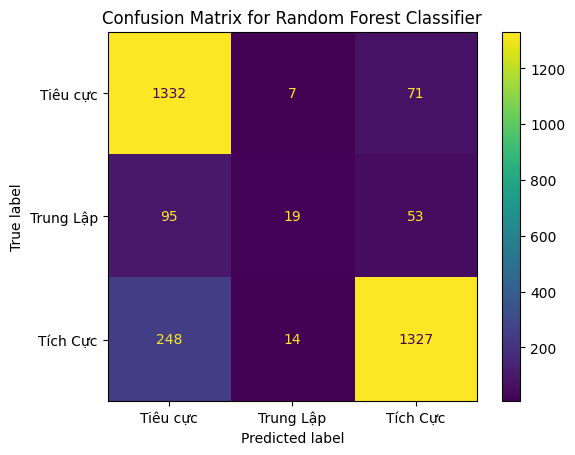

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_RF_phrase, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title("Confusion Matrix for Random Forest Classifier")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_RF_phrase, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.80      0.94      0.86      1410
   Trung Lập       0.47      0.11      0.18       167
    Tích Cực       0.91      0.84      0.87      1589

    accuracy                           0.85      3166
   macro avg       0.73      0.63      0.64      3166
weighted avg       0.84      0.85      0.83      3166



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNC = KNeighborsClassifier(n_jobs=-1)
KNC.fit(X_train_val_dense, y_train_val)
y_pred_KNN = KNC.predict(X_test_dense)
print(f'Accuracy on test set: {KNC.score(X_test_dense, y_test)}')


Accuracy on test set: 0.8436512950094757


Text(0.5, 1.0, 'Confusion Matrix for K-Nearest Neighbors Classifier')

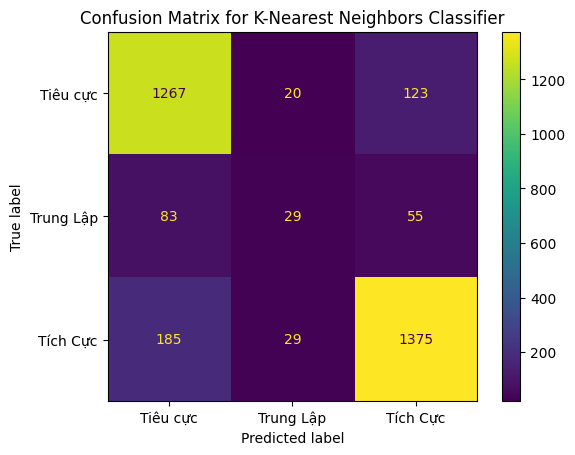

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_KNN, labels=KNC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title("Confusion Matrix for K-Nearest Neighbors Classifier")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_KNN, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.83      0.90      0.86      1410
   Trung Lập       0.37      0.17      0.24       167
    Tích Cực       0.89      0.87      0.88      1589

    accuracy                           0.84      3166
   macro avg       0.69      0.65      0.66      3166
weighted avg       0.83      0.84      0.83      3166



Accuracy on test set: 0.5533796588755527
              precision    recall  f1-score   support

    Tiêu cực       0.72      0.32      0.44      1410
   Trung Lập       0.13      0.45      0.20       167
    Tích Cực       0.63      0.78      0.69      1589

    accuracy                           0.55      3166
   macro avg       0.49      0.51      0.44      3166
weighted avg       0.64      0.55      0.55      3166



Text(0.5, 1.0, 'Confusion Matrix for Gaussian Naive Bayes')

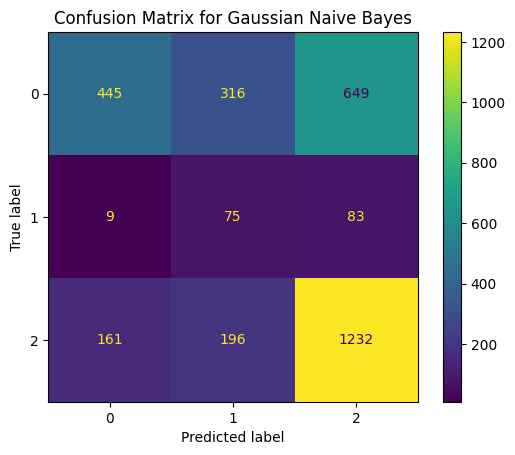

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
GNB = GaussianNB(var_smoothing=1e-7)
GNB.fit(X_train_val_dense, y_train_val)
y_pred_GNB = GNB.predict(X_test_dense)
print(f'Accuracy on test set: {GNB.score(X_test_dense, y_test)}')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_GNB, target_names=label_name))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_GNB, labels=GNB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GNB.classes_)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Gaussian Naive Bayes')


Accuracy on test set: 0.7574226152874289
              precision    recall  f1-score   support

    Tiêu cực       0.72      0.85      0.78      1410
   Trung Lập       0.30      0.25      0.27       167
    Tích Cực       0.85      0.73      0.78      1589

    accuracy                           0.76      3166
   macro avg       0.62      0.61      0.61      3166
weighted avg       0.76      0.76      0.76      3166



Text(0.5, 1.0, 'Confusion Matrix for Bernouli Naive Bayes')

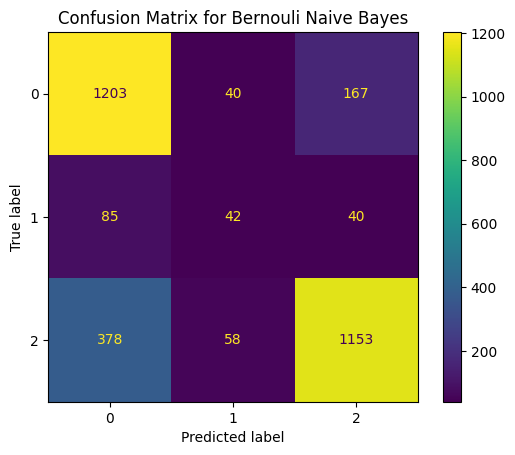

In [ ]:
from sklearn.naive_bayes import  BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train_val_dense, y_train_val)
y_pred_BNB = BNB.predict(X_test_dense)
print(f'Accuracy on test set: {BNB.score(X_test_dense, y_test)}')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_BNB, target_names=label_name))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_BNB, labels=BNB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=BNB.classes_)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Bernouli Naive Bayes')


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_GNB, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.72      0.32      0.44      1410
   Trung Lập       0.13      0.45      0.20       167
    Tích Cực       0.63      0.78      0.69      1589

    accuracy                           0.55      3166
   macro avg       0.49      0.51      0.44      3166
weighted avg       0.64      0.55      0.55      3166



In [ ]:
!pip install xgboost

In [ ]:
from sklearn.svm import SVC
# Khởi tạo mô hình với các tham số cụ thể
svc = SVC(
    class_weight='balanced',
)

# Huấn luyện mô hình
svc.fit(X_train_val_dense, y_train_val)

# Dự đoán và đánh giá
y_pred_SVC = svc.predict(X_test_dense)
accuracy = svc.score(X_test_dense, y_test)
print(f'Accuracy on test set: {accuracy:.2f}')


Accuracy on test set: 0.85


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_SVC, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.89      0.88      0.89      1410
   Trung Lập       0.30      0.60      0.40       167
    Tích Cực       0.95      0.86      0.90      1589

    accuracy                           0.85      3166
   macro avg       0.71      0.78      0.73      3166
weighted avg       0.89      0.85      0.87      3166



Text(0.5, 1.0, 'Confusion Matrix for Support Vector Machine')

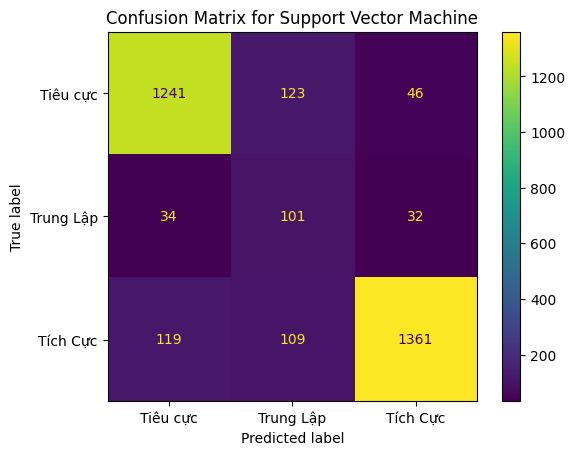

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_SVC, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Support Vector Machine')

In [ ]:
from sklearn.linear_model import SGDClassifier
sgdClassifier = SGDClassifier(max_iter=10000, tol=1e-6)
sgdClassifier.fit(X_train_val_dense, y_train_val)

y_pred_sgd = sgdClassifier.predict(X_test_dense)
accuracy = sgdClassifier.score(X_test_dense, y_test)
print(f'Accuracy on test set: {accuracy:.2f}')

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_sgd, target_names=label_name))

Accuracy on test set: 0.89
              precision    recall  f1-score   support

    Tiêu cực       0.88      0.94      0.91      1410
   Trung Lập       0.68      0.17      0.27       167
    Tích Cực       0.91      0.92      0.91      1589

    accuracy                           0.89      3166
   macro avg       0.82      0.68      0.70      3166
weighted avg       0.88      0.89      0.88      3166



Text(0.5, 1.0, 'Confusion Matrix for Linear Support Vector Machine')

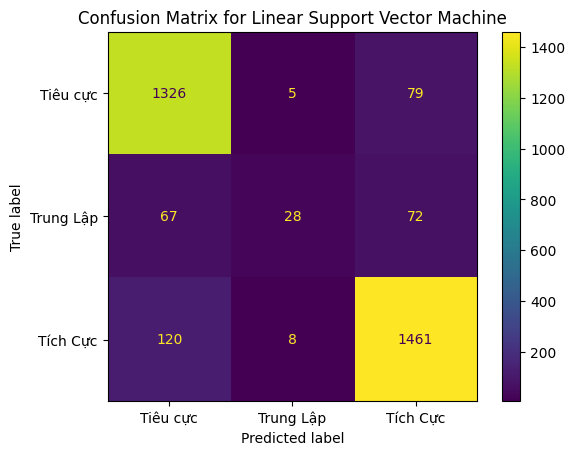

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_sgd, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Linear Support Vector Machine')

Accuracy on test set: 0.885028427037271
              precision    recall  f1-score   support

    Tiêu cực       0.88      0.93      0.90      1410
   Trung Lập       0.49      0.22      0.30       167
    Tích Cực       0.91      0.92      0.91      1589

    accuracy                           0.89      3166
   macro avg       0.76      0.69      0.71      3166
weighted avg       0.87      0.89      0.88      3166



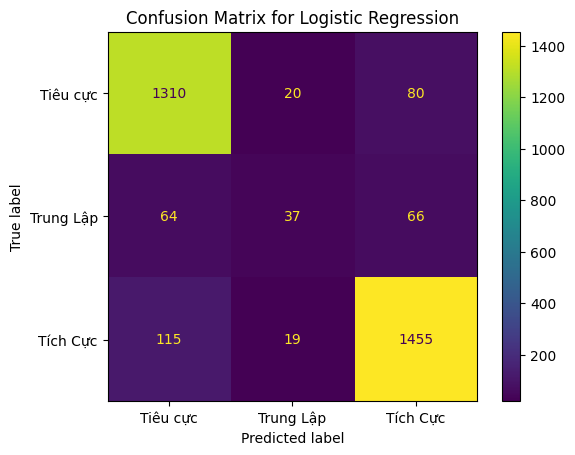

In [ ]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression(
    max_iter=100000,
    tol=1e-8,
    random_state=2004,
    warm_start=True, n_jobs=14
)

# Huấn luyện mô hình
logistic_regression.fit(X_train_val_dense, y_train_val)

# Dự đoán
y_pred_logistic_regression = logistic_regression.predict(X_test_dense)

# Đánh giá mô hình
accuracy = logistic_regression.score(X_test_dense, y_test)
print(f'Accuracy on test set: {accuracy}')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_logistic_regression, labels=logistic_regression.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Logistic Regression')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_logistic_regression, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.87      0.93      0.90      1410
   Trung Lập       0.61      0.20      0.30       167
    Tích Cực       0.91      0.91      0.91      1589

    accuracy                           0.88      3166
   macro avg       0.80      0.68      0.70      3166
weighted avg       0.87      0.88      0.87      3166



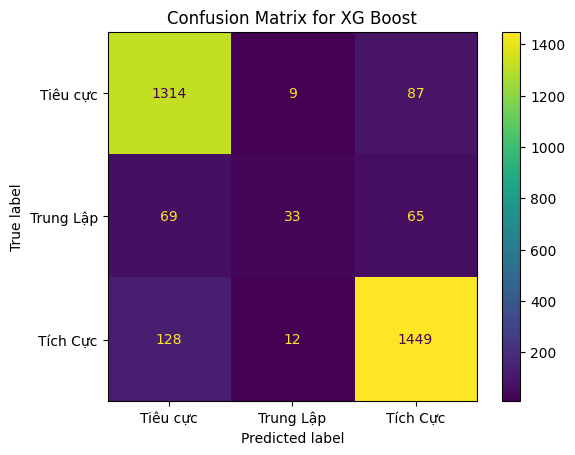

In [28]:
from xgboost import XGBClassifier

# XGB cho bài toán phân loại
xgb = XGBClassifier(max_depth=6, n_estimators=200)
xgb.fit(X_train_val_dense, y_train_val)
y_pred_xgb = xgb.predict(X_test_dense)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for XG Boost')

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.88      0.93      0.90      1410
   Trung Lập       0.51      0.23      0.32       167
    Tích Cực       0.91      0.91      0.91      1589

    accuracy                           0.88      3166
   macro avg       0.77      0.69      0.71      3166
weighted avg       0.87      0.88      0.88      3166



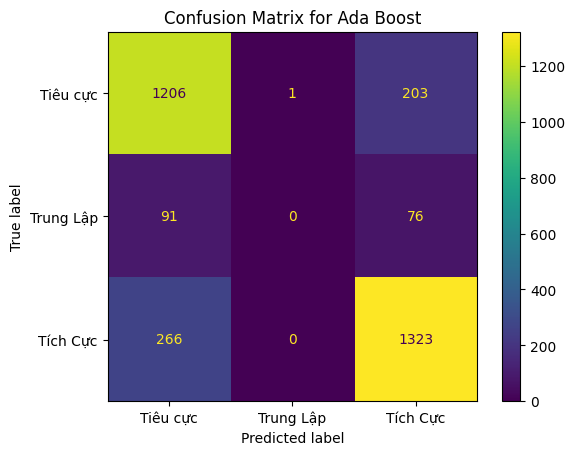

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# XGB cho bài toán phân loại
ada = AdaBoostClassifier()
ada.fit(X_train_val_dense, y_train_val)
y_pred_ada = ada.predict(X_test_dense)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_ada, labels=ada.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Ada Boost')

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_ada, target_names=label_name,))